In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


### Estimação de s4 com vtec

The scores for the k-fold crossvalidation was:
[-0.00287525 -0.00252505 -0.00298634 -0.00279231 -0.00337385 -0.00322356
 -0.00293102 -0.00299216 -0.00361726 -0.00297627] 

O erro quadrático médio foi: 0.002787
O erro quadrático total foi: 3.167663
O maior erro por previsão foi: 0.397122
O erro relativo foi: 12.797206%
O número de verdadeiros negativos foi: 2783
O número de verdadeiros positivos foi: 118
O número de falsos negativos foi: 259
O número de falsos positivos foi: 440
O POD foi: 0.312997
O FAR foi: 0.788530
A ACC foi: 0.805833
O kappa foi: 0.059623

Error for the time series sample:
O erro quadrático médio foi: 0.008551
O erro quadrático total foi: 2.402453
O maior erro por previsão foi: 0.592039
O erro relativo foi: 15.062355%
O número de verdadeiros negativos foi: 538
O número de verdadeiros positivos foi: 28
O número de falsos negativos foi: 56
O número de falsos positivos foi: 53
O POD foi: 0.333333
O FAR foi: 0.654321
A ACC foi: 0.838519
O kappa foi: 0.069382


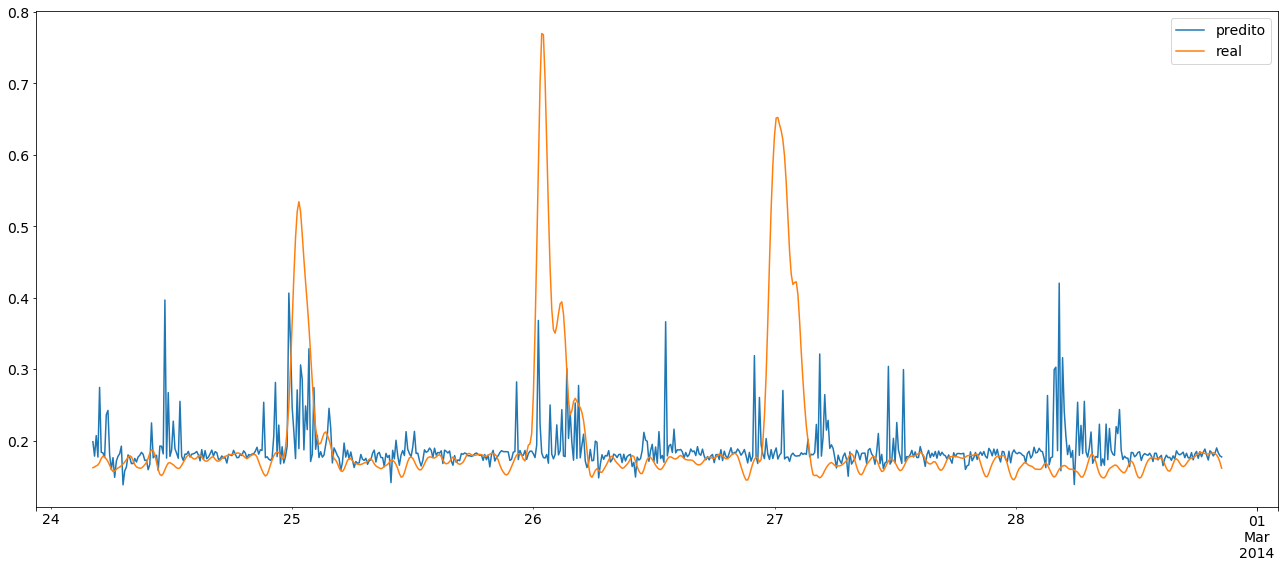

In [4]:
instances_set = ['vtec']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
df_aux.plot(figsize=(18, 8));
plt.tight_layout()
#plt.savefig('./images/regression_random_florest.eps', format='eps', dpi=1000)

### Estimação de s4 com vtec, vtec_dt e vtec_dt2

The scores for the k-fold crossvalidation was:
[-0.0018902  -0.00151451 -0.00173288 -0.00229025 -0.00222399 -0.00231989
 -0.00206792 -0.0018027  -0.00206172 -0.00209766] 

O erro quadrático médio foi: 0.001821
O erro quadrático total foi: 2.560493
O maior erro por previsão foi: 0.382724
O erro relativo foi: 10.053072%
O número de verdadeiros negativos foi: 2811
O número de verdadeiros positivos foi: 246
O número de falsos negativos foi: 131
O número de falsos positivos foi: 412
O POD foi: 0.652520
O FAR foi: 0.626140
A ACC foi: 0.849167
O kappa foi: 0.036234

Error for the time series sample:
O erro quadrático médio foi: 0.007391
O erro quadrático total foi: 2.233576
O maior erro por previsão foi: 0.524127
O erro relativo foi: 16.386913%
O número de verdadeiros negativos foi: 512
O número de verdadeiros positivos foi: 56
O número de falsos negativos foi: 28
O número de falsos positivos foi: 79
O POD foi: 0.666667
O FAR foi: 0.585185
A ACC foi: 0.841481
O kappa foi: 0.041174


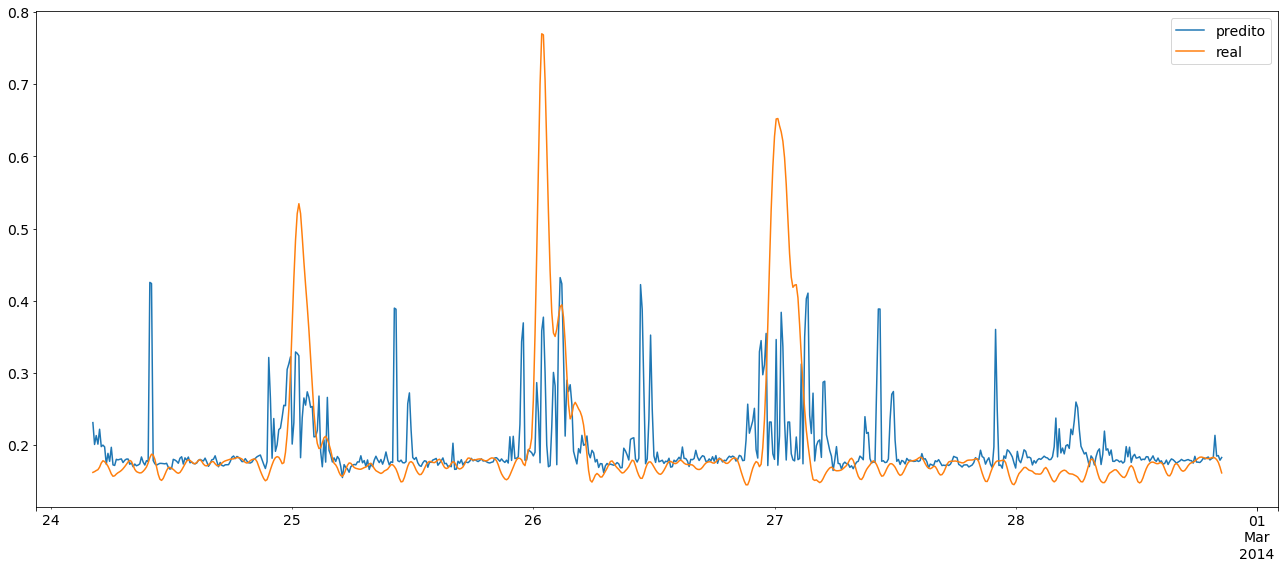

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
df_aux.plot(figsize=(18, 8));
plt.tight_layout()


#plt.savefig('./images/regression_random_florest.eps', format='eps', dpi=1000)

### Estimação de S4 com vtec, gvtec1 e gvtec2

The scores for the k-fold crossvalidation was:
[-0.00151115 -0.00142363 -0.00161576 -0.00151574 -0.00154245 -0.00145353
 -0.00178629 -0.0016339  -0.00165121 -0.00151906] 

O erro quadrático médio foi: 0.001457
O erro quadrático total foi: 2.290191
O maior erro por previsão foi: 0.373275
O erro relativo foi: 8.619484%
O número de verdadeiros negativos foi: 2915
O número de verdadeiros positivos foi: 262
O número de falsos negativos foi: 115
O número de falsos positivos foi: 308
O POD foi: 0.694960
O FAR foi: 0.540351
A ACC foi: 0.882500
O kappa foi: 0.032093

Error for the time series sample:
O erro quadrático médio foi: 0.006728
O erro quadrático total foi: 2.131121
O maior erro por previsão foi: 0.579235
O erro relativo foi: 15.293386%
O número de verdadeiros negativos foi: 520
O número de verdadeiros positivos foi: 54
O número de falsos negativos foi: 30
O número de falsos positivos foi: 71
O POD foi: 0.642857
O FAR foi: 0.568000
A ACC foi: 0.850370
O kappa foi: 0.042653


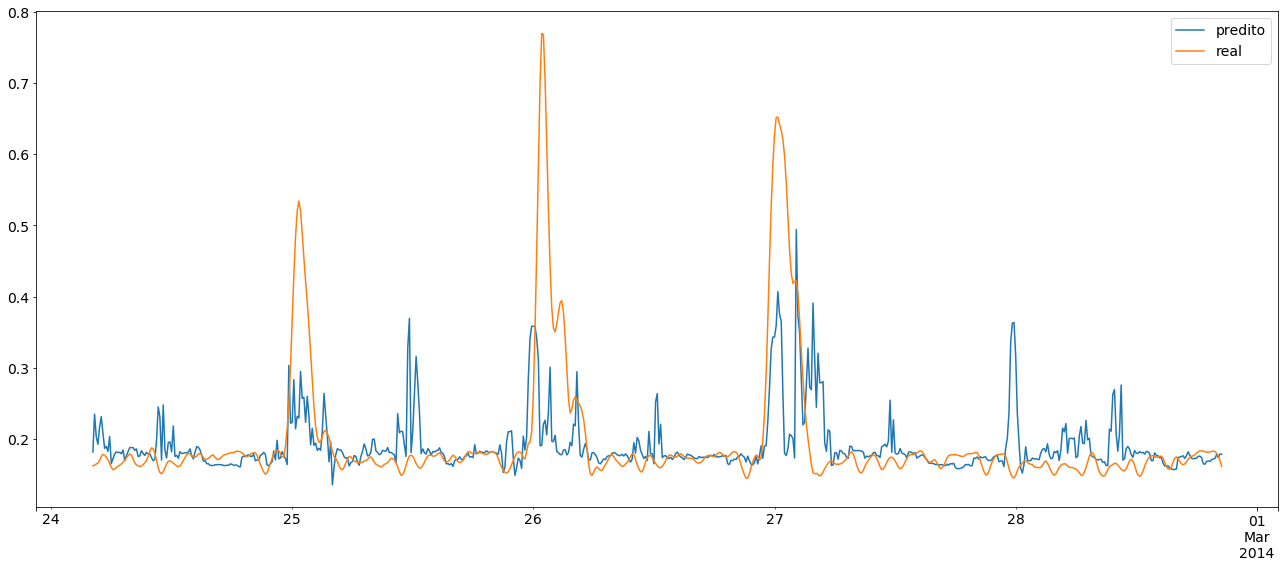

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
df_aux.plot(figsize=(18, 8));
plt.tight_layout()
plt.savefig('./images/regression_random_florest.eps', format='eps', dpi=1000)